In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
output_dir = "../2026-01-28"
test_output_dir = output_dir + "_test"

In [2]:
import os
import sys
import json
from pathlib import Path
from datasets import load_dataset
from dotenv import load_dotenv

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), '..'))

load_dotenv()

ds = load_dataset("SimpleStories/SimpleStories", split="train")
print("Dataset features:")
print(ds.features)
print(f"\nDataset size: {len(ds)}")
print(f"\nFirst example keys: {list(ds[0].keys())}")

/home/jjb/msc/axiom-guided-structured-reasoning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset features:
{'story': Value('string'), 'topic': Value('string'), 'theme': Value('string'), 'style': Value('string'), 'feature': Value('string'), 'grammar': Value('string'), 'persona': Value('string'), 'initial_word_type': Value('string'), 'initial_letter': Value('string'), 'word_count': Value('int64'), 'character_count': Value('int64'), 'num_paragraphs': Value('int64'), 'avg_word_length': Value('float64'), 'avg_sentence_length': Value('float64'), 'flesch_reading_ease': Value('float64'), 'flesch_kincaid_grade': Value('float64'), 'dale_chall_readability_score': Value('float64'), 'num_stories_in_completion': Value('int64'), 'expected_num_stories_in_completion': Value('int64'), 'generation_id': Value('string'), 'model': Value('string')}

Dataset size: 2115696

First example keys: ['story', 'topic', 'theme', 'style', 'feature', 'grammar', 'persona', 'initial_word_type', 'initial_letter', 'word_count', 'character_count', 'num_paragraphs', 'avg_word_length', 'avg_sentence_length', 'fles

In [4]:
# Run the dataset exploration script
from explore_dataset import explore_dataset, propose_leaf_nodes

# Explore the dataset
categorical_features, numeric_features = explore_dataset(sample_size=50000)

# Propose leaf nodes
leaf_nodes = propose_leaf_nodes(categorical_features, numeric_features)

print(f"\n✓ Generated {len(leaf_nodes)} leaf nodes")
print("\nFirst 10 leaf nodes:")
for i, node in enumerate(leaf_nodes[:10], 1):
    print(f"{i:2d}. {node['id']}: {node['description']}")


Analyzing 50000 examples from 2115696 total examples...

Most common categorical values:

topic (48 unique):
  hidden treasures: 1123
  magical lands: 1105
  bygone eras: 1094
  the arts: 1092
  cultural traditions: 1086
  seasonal changes: 1080
  giant creatures: 1079
  mystical creatures: 1076
  time travel: 1073
  lost civilizations: 1073

theme (63 unique):
  Magic: 878
  Deception: 853
  Helping Others: 852
  Agency: 847
  Innovation: 840
  Kindness: 831
  Problem-Solving: 827
  Humor: 819
  Growth: 817
  Hardship: 814

style (23 unique):
  minimalist: 2325
  classic: 2255
  lighthearted: 2216
  playful: 2215
  modern: 2209
  surreal: 2208
  philosophical: 2199
  humorous: 2181
  tragic: 2180
  fable-like: 2180

feature (26 unique):
  a flashback: 2021
  circular narrative structure: 2013
  a cliffhanger: 1994
  a Red Herring: 1986
  juxtaposition: 1981
  a story within a story: 1961
  Checkhov's gun: 1958
  a moral lesson: 1950
  absence indicating a presence: 1949
  symbolism: 1

In [ ]:
output_file = 'proposed_leaf_nodes.json'
with open(output_file, 'w') as f:
    json.dump(leaf_nodes, f, indent=2)

In [4]:
from generate_codebooks import CodebookGenerator
generator = CodebookGenerator(model="gpt-5-mini-2025-08-07")

# Load the proposed leaf nodes
leaf_nodes = generator.load_leaf_nodes(output_file)
print(f"Loaded {len(leaf_nodes)} leaf nodes")

NameError: name 'output_file' is not defined

In [ ]:
# Generate a small test codebook
test_codebook = generator.generate_codebook(
    leaf_nodes[:8],  # Use first 8 leaf nodes
    size="small",
    difficulty="easy",
    use_all_formulas=False
)

print("Generated Codebook:")
print("=" * 60)
print(test_codebook)
print("=" * 60)


In [ ]:
# Generate obfuscated version
obfuscated_codebook = generator.obfuscate_codebook(test_codebook)

print("Obfuscated Codebook:")
print("=" * 60)
print(obfuscated_codebook)
print("=" * 60)


In [ ]:
generator.generate_all_codebooks(
    output_dir=output_dir,
    small_count=20,
    medium_count=15,
    large_count=10,
    insane_count=5
)

## Step 6: Generate Individual Codebooks

Generate specific codebooks with custom parameters.


In [ ]:
medium_codebook = generator.generate_codebook(
    leaf_nodes,
    size="medium",
    difficulty="easy",
    use_all_formulas=True
)

print("Medium Codebook with All Formulas:")
print("=" * 60)
print(medium_codebook)
print("=" * 60)

# Save it
generator.save_codebook(medium_codebook, "example-medium.txt", output_dir=test_output_dir)

# Generate and save obfuscated version
obfuscated_medium = generator.obfuscate_codebook(medium_codebook)
generator.save_codebook(obfuscated_medium, "example-medium-obfc.txt", output_dir=test_output_dir)


## Step 7: Verify Generated Codebooks

Parse a generated codebook to verify it's valid.


In [ ]:
test_codebook = medium_codebook

from parser import CodebookParser

parser = CodebookParser()

test_file = Path(test_output_dir) / "test-codebook.txt"
test_file.parent.mkdir(exist_ok=True)
with open(test_file, 'w') as f:
    f.write(test_codebook)

try:
    graph = parser.parse_codebook(str(test_file))
    print(f"✓ Successfully parsed codebook!")
    print(f"  Nodes: {len(graph.nodes)}")
    print(f"  Edges: {len(graph.edges)}")
    print(f"\nNodes:")
    for node in graph.nodes:
        formula_type = type(node.formula).__name__ if node.formula else "None"
        print(f"  - {node.id}: {formula_type}")
except Exception as e:
    print(f"✗ Error parsing codebook: {e}")


## Step 8: Rewrite Codebooks in Different Styles


In [12]:
from rewrite_codebooks import CodebookRewriter

rewriter = CodebookRewriter(model="gpt-5-mini-2025-08-07")

print("Available styles:")
for style in CodebookRewriter.STYLES:
    print(f"  - {style}: {CodebookRewriter.STYLE_DESCRIPTIONS[style]}")


Available styles:
  - free-flow: Natural, conversational, flowing text that reads smoothly without rigid structure
  - transcript: Dialogue-like, interview style with questions and answers, as if explaining to someone
  - technical: Precise, formal technical language with clear definitions and specifications
  - structured: Clear, organized format with bullet points, sections, and hierarchical organization
  - flowery: Extended, descriptive, elaborate language with rich vocabulary and detailed explanations
  - concise: Brief, to-the-point style with minimal words while maintaining clarity
  - narrative: Story-like, engaging narrative style that weaves concepts together like a story


In [ ]:
test_codebook_file = Path(test_output_dir) / "test-codebook.txt"

if test_codebook_file.exists():
    style = "flowery"
    rewritten = rewriter.rewrite_codebook_file(str(test_codebook_file), style)
    print(f"✓ Rewritten in {style} style")
    print(f"  Saved to: {rewritten}")
    
    with open(rewritten, 'r') as f:
        rewritten_text = f.read()
    print(f"\nFirst 500 characters of {style} version:")
    print("=" * 60)
    print(rewritten_text[:500])
    print("=" * 60)
else:
    print(f"Test codebook not found at {test_codebook_file}")


# Step 9: Verify rewritten codebook

In [ ]:
from parser import CodebookParser

parser = CodebookParser()

test_rewritten_file = Path(test_output_dir) / "test-codebook-flowery.txt"

if test_rewritten_file.exists():
    try:
        graph = parser.parse_codebook(str(test_rewritten_file))
        print(f"✓ Successfully parsed rewritten codebook!")
        print(f"  Nodes: {len(graph.nodes)}")
        print(f"  Edges: {len(graph.edges)}")
        print(f"\nNodes (first 10):")
        for node in graph.nodes[:10]:
            formula_type = type(node.formula).__name__ if node.formula else "None"
            print(f"  - {node.id}: {formula_type}")
        
        # Compare with original
        original_file = Path(test_output_dir) / "test-codebook.txt"
        if original_file.exists():
            original_graph = parser.parse_codebook(str(original_file))
            print(f"\nComparison:")
            print(f"  Original nodes: {len(original_graph.nodes)}")
            print(f"  Rewritten nodes: {len(graph.nodes)}")
            print(f"  Original edges: {len(original_graph.edges)}")
            print(f"  Rewritten edges: {len(graph.edges)}")
            
            # Check if node IDs match
            original_ids = {node.id for node in original_graph.nodes}
            rewritten_ids = {node.id for node in graph.nodes}
            if original_ids == rewritten_ids:
                print(f"  ✓ All node IDs match!")
            else:
                print(f"  ⚠ Node ID mismatch!")
                print(f"    Missing: {original_ids - rewritten_ids}")
                print(f"    Extra: {rewritten_ids - original_ids}")
    except Exception as e:
        print(f"✗ Error parsing rewritten codebook: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"Rewritten codebook not found at {test_rewritten_file}")
    print("Run the rewriting step above first.")


## Step 10: Rewrite All Codebooks in Directory

Rewrite all codebooks in a directory with all available styles. This will create multiple versions of each codebook.


## Complete Pipeline Script

Use the `pipeline.py` script to run the entire process automatically:
1. Generate codebooks
2. Obfuscate originals
3. Rewrite in different styles
4. Obfuscate rewritten versions
5. Parse and serialize all codebooks


In [4]:
# Run the complete pipeline
from pipeline import CodebookPipeline

# Initialize pipeline
pipeline = CodebookPipeline(
    model="gpt-5-mini-2025-08-07", # "gpt-5.2-2025-12-11",
    rewrite_styles=None  # None = all styles, or specify: ["flowery", "technical"]
)



pipeline.run_full_pipeline(
    output_dir=output_dir,
    small_count=20,
    medium_count=20,
    large_count=10,
    insane_count=5
)

CODEBOOK GENERATION PIPELINE
Output directory: /home/jjb/msc/axiom-guided-structured-reasoning/codebooks/generator/../2026-01-28
Rewriting styles: free-flow, transcript, technical, structured, flowery, concise, narrative

Step 1: Generating codebooks...
--------------------------------------------------------------------------------
Generating 2 codebooks in parallel...


Generating codebooks: 100%|██████████| 2/2 [00:53<00:00, 26.93s/it]



✓ Processed 55 codebooks
  Skipped 53 existing original codebooks
  Skipped 55 existing obfuscated codebooks
  Output directory: /home/jjb/msc/axiom-guided-structured-reasoning/codebooks/generator/../2026-01-28

Step 2: Obfuscating original codebooks...
--------------------------------------------------------------------------------
Skipping 55 already obfuscated files.
All original codebooks already obfuscated.

Step 3: Rewriting codebooks in different styles...
--------------------------------------------------------------------------------
Skipping 367 already rewritten files.
Rewriting 55 codebooks in 7 styles (18 files to create)...
Rewriting 18 codebooks in parallel...


Rewriting codebooks: 100%|██████████| 18/18 [00:58<00:00,  3.26s/it]



Step 4: Obfuscating rewritten codebooks...
--------------------------------------------------------------------------------
Skipping 369 already obfuscated rewritten files.
Obfuscating 16 rewritten codebooks...


Obfuscating rewritten: 100%|██████████| 16/16 [00:00<00:00, 230.02it/s, file=cb-016-small-medium-allf-trans]



Step 5: Parsing and serializing all codebooks...
--------------------------------------------------------------------------------
Skipping 842 already parsed files.
Parsing and serializing 38 codebook files...


Parsing codebooks: 100%|██████████| 38/38 [02:18<00:00,  3.63s/it]



Parsing complete: 37 successful, 1 failed

Step 6: Visualizing all graphs...
--------------------------------------------------------------------------------
Visualizing 879 graphs...


Visualizing: 100%|██████████| 879/879 [01:31<00:00,  9.63it/s, file=cb-011-small-medium-allf-, success=879, failed=0]



Visualization complete: 879 successful, 0 failed

Step 7: Verifying graph equality...
--------------------------------------------------------------------------------
Verifying 55 codebook groups...


Verifying: 100%|██████████| 55/55 [00:40<00:00,  1.36it/s]


Verification complete: 9 equal, 46 unequal codebooks logged to ../2026-01-28/logs/graph_equality_log_20260128_122331.txt

✓ PIPELINE COMPLETE!
All files saved to: /home/jjb/msc/axiom-guided-structured-reasoning/codebooks/generator/../2026-01-28


Using graph equality log: ../2026-01-28/logs/graph_equality_log_20260128_122331.txt
Parsed 46 unequal codebooks from log

=== Style performance (top 10 by probability of being in largest group) ===
flowery         obf=0     | p_in_largest=0.913 (n=46)
base            obf=0     | p_in_largest=0.848 (n=46)
transcript      obf=0     | p_in_largest=0.848 (n=46)
narrative       obf=0     | p_in_largest=0.826 (n=46)
concise         obf=0     | p_in_largest=0.783 (n=46)
free-flow       obf=0     | p_in_largest=0.783 (n=46)
structured      obf=0     | p_in_largest=0.761 (n=46)
technical       obf=0     | p_in_largest=0.761 (n=46)
flowery         obf=1     | p_in_largest=0.644 (n=45)
narrative       obf=1     | p_in_largest=0.522 (n=46)

=== Style performance (bottom 10 by probability of being in largest group) ===
structured      obf=0     | p_in_largest=0.761 (n=46)
technical       obf=0     | p_in_largest=0.761 (n=46)
flowery         obf=1     | p_in_largest=0.644 (n=45)
narrative       obf=

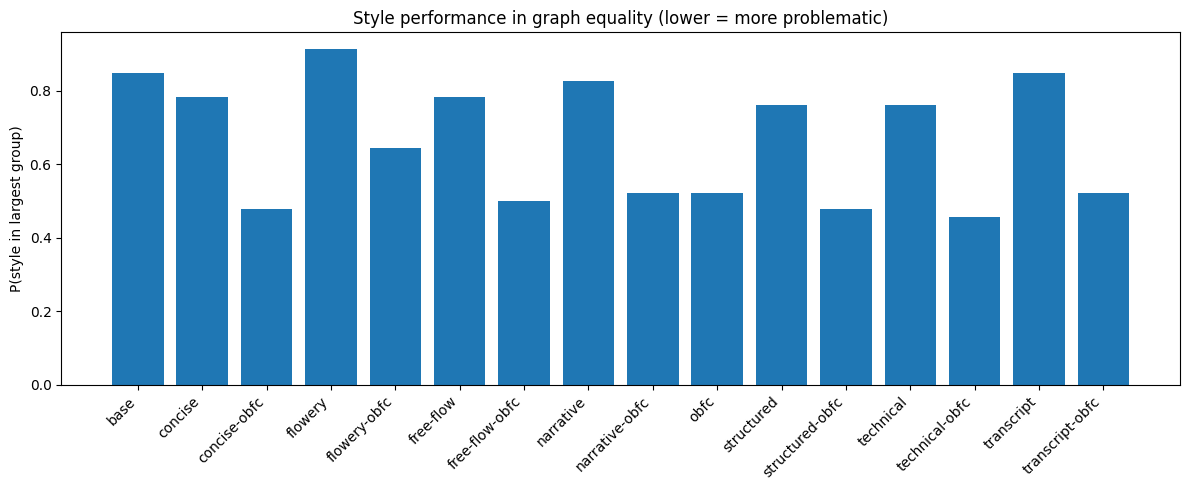

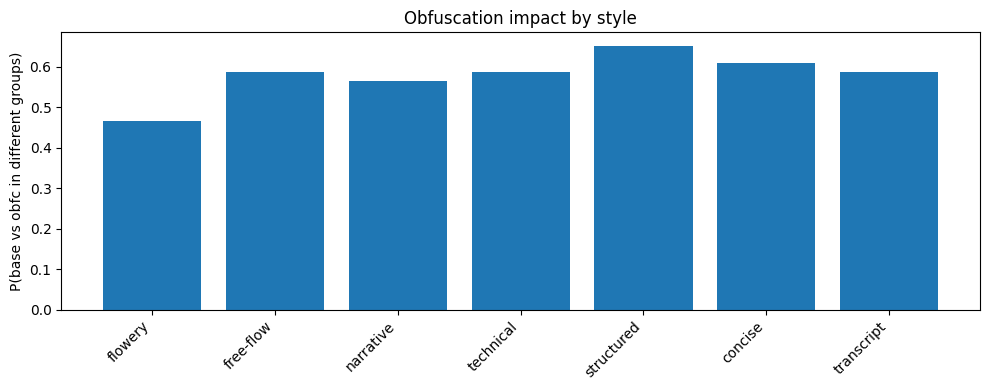


Finished graph equality statistics analysis.


In [6]:
# Analyze graph equality results

from pathlib import Path
import re
from collections import defaultdict, Counter
import math
import matplotlib.pyplot as plt

# Use the same output_dir as above and pick the latest graph equality log
logs_dir = Path(output_dir) / "logs"
log_files = sorted(logs_dir.glob("graph_equality_log_*.txt"))
if not log_files:
    raise FileNotFoundError(f"No graph equality logs found in {logs_dir}")

log_file = log_files[-1]
print(f"Using graph equality log: {log_file}")

# Example line formats we parse:
# cb-038-medium-hard
#   Group: 15 (base, concise, concise-obfc, ...)

codebook_groups = {}  # cb_id -> list of (group_size, [styles])
current_cb = None

with open(log_file, "r") as f:
    for raw_line in f:
        line = raw_line.strip()
        if not line:
            continue
        # Detect codebook id line
        if line.startswith("cb-"):
            current_cb = line
            codebook_groups[current_cb] = []
            continue
        # Detect group lines while inside a codebook block
        if current_cb and line.startswith("Group:"):
            # Example: "Group: 15 (base, concise, concise-obfc, ...)"
            m = re.match(r"Group:\s*(\d+)\s*\((.*?)\)", line)
            if not m:
                continue
            size = int(m.group(1))
            styles = [s.strip() for s in m.group(2).split(",") if s.strip()]
            codebook_groups[current_cb].append((size, styles))

# Sanity check
print(f"Parsed {len(codebook_groups)} unequal codebooks from log")

# Compute per-codebook agreement statistics
codebook_stats = {}

for cb_id, groups in codebook_groups.items():
    total = sum(size for size, _ in groups)
    if total == 0:
        continue
    largest_group_size = max(size for size, _ in groups)
    agreement_ratio = largest_group_size / total
    num_groups = len(groups)
    singleton_groups = sum(1 for size, _ in groups if size == 1)
    codebook_stats[cb_id] = {
        "total_variants": total,
        "largest_group_size": largest_group_size,
        "agreement_ratio": agreement_ratio,
        "num_groups": num_groups,
        "singleton_groups": singleton_groups,
    }

# Style-level statistics
style_appearances = Counter()           # how often each style appears at all
style_in_largest_group = Counter()      # how often style is in the largest group
style_singleton = Counter()             # how often style is in a singleton group

# For obfuscation impact (style vs style-obfc)
# We treat any style that ends with "-obfc" as obfuscated variant
style_pair_mismatch = Counter()   # for each base style, how often style and style-obfc end up in different groups
style_pair_total = Counter()

for cb_id, groups in codebook_groups.items():
    # Determine largest group size for this codebook
    largest_size = max(size for size, _ in groups)

    # Map style -> group index
    style_to_group = {}
    for gi, (size, styles) in enumerate(groups):
        for s in styles:
            style_appearances[s] += 1
            style_to_group[s] = gi
            if size == largest_size:
                style_in_largest_group[s] += 1
            if size == 1:
                style_singleton[s] += 1

    # For each base style, compare with its obfuscated partner if both exist
    # We consider names like "technical-obfc"; base style is everything before suffix "-obfc"
    all_styles = set(style_to_group.keys())
    for s in list(all_styles):
        if s.endswith("-obfc"):
            base = s[:-5]
            obf = s
            if base in all_styles:
                style_pair_total[base] += 1
                if style_to_group[base] != style_to_group[obf]:
                    style_pair_mismatch[base] += 1

# Aggregate styles into (base_style, obfuscated) buckets
# e.g. ("technical", False) for "technical", ("technical", True) for "technical-obfc"
agg_appearances = Counter()
agg_in_largest = Counter()
agg_singleton = Counter()

for style, count in style_appearances.items():
    if style.endswith("-obfc"):
        base_style = style[:-5]
        obf = True
    else:
        base_style = style
        obf = False
    key = (base_style, obf)
    agg_appearances[key] += count
    agg_in_largest[key] += style_in_largest_group.get(style, 0)
    agg_singleton[key] += style_singleton.get(style, 0)

# Compute performance metrics per aggregated style bucket
style_perf_rows = []
for (base_style, obf), count in sorted(agg_appearances.items()):
    in_largest = agg_in_largest[(base_style, obf)]
    singletons = agg_singleton[(base_style, obf)]
    style_perf_rows.append({
        "style": base_style,
        "obfuscated": obf,
        "appearances": count,
        "in_largest": in_largest,
        "p_in_largest": in_largest / count if count else math.nan,
        "singleton_groups": singletons,
        "p_singleton": singletons / count if count else math.nan,
    })

# Convert to simple sorted views for printing
# Best / worst by probability of being in the largest group
style_perf_rows_sorted = sorted(
    style_perf_rows,
    key=lambda r: r["p_in_largest"],
    reverse=True,
)

print("\n=== Style performance (top 10 by probability of being in largest group) ===")
for row in style_perf_rows_sorted[:10]:
    print(f"{row['style']:<15} obf={row['obfuscated']:<5} | p_in_largest={row['p_in_largest']:.3f} (n={row['appearances']})")

print("\n=== Style performance (bottom 10 by probability of being in largest group) ===")
for row in style_perf_rows_sorted[-10:]:
    print(f"{row['style']:<15} obf={row['obfuscated']:<5} | p_in_largest={row['p_in_largest']:.3f} (n={row['appearances']})")

# Obfuscation impact summary
print("\n=== Obfuscation impact per style (base vs base-obfc) ===")
for base_style, total in sorted(style_pair_total.items(), key=lambda x: x[0]):
    mismatches = style_pair_mismatch[base_style]
    p_mismatch = mismatches / total if total else math.nan
    print(f"{base_style:<15} | comparisons={total:3d}  mismatches={mismatches:3d}  p_mismatch={p_mismatch:.3f}")

# Agreement extremes
if codebook_stats:
    sorted_by_agreement = sorted(
        codebook_stats.items(), key=lambda kv: kv[1]["agreement_ratio"], reverse=True
    )
    print("\n=== Codebooks with highest agreement (top 10) ===")
    for cb_id, stats in sorted_by_agreement[:10]:
        print(f"{cb_id}: agreement={stats['agreement_ratio']:.3f}, largest_group={stats['largest_group_size']}/{stats['total_variants']} groups={stats['num_groups']}")

    print("\n=== Codebooks with lowest agreement (bottom 10) ===")
    for cb_id, stats in sorted_by_agreement[-10:]:
        print(f"{cb_id}: agreement={stats['agreement_ratio']:.3f}, largest_group={stats['largest_group_size']}/{stats['total_variants']} groups={stats['num_groups']}")

# Optional: visualize style performance
try:
    # Bar chart: probability of being in largest group by (style, obf)
    labels = [f"{r['style']}{'-obfc' if r['obfuscated'] else ''}" for r in style_perf_rows]
    probs = [r["p_in_largest"] for r in style_perf_rows]

    plt.figure(figsize=(12, 5))
    plt.bar(range(len(labels)), probs)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.ylabel("P(style in largest group)")
    plt.title("Style performance in graph equality (lower = more problematic)")
    plt.tight_layout()
    plt.show()

    # Bar chart: obfuscation mismatch rate per base style
    if style_pair_total:
        base_styles = list(style_pair_total.keys())
        mismatch_rates = [style_pair_mismatch[s] / style_pair_total[s] for s in base_styles]

        plt.figure(figsize=(10, 4))
        plt.bar(range(len(base_styles)), mismatch_rates)
        plt.xticks(range(len(base_styles)), base_styles, rotation=45, ha="right")
        plt.ylabel("P(base vs obfc in different groups)")
        plt.title("Obfuscation impact by style")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Visualization failed: {e}")

print("\nFinished graph equality statistics analysis.")
